# Import state space matrices, add controller, apply seismic motion to specific input

This example contains active damping of the resonances of a triple suspension system as used in the LIGO Gravitational-wave detectors. These suspension systems can be described via a State-Space system with 24 inputs and 18 outputs. Each stage has in- and outputs in 6 DOFs (x, y, z, roll, pitch, yaw), with the exception of the suspension point, which has only 6 inputs. Thus, the total system has 6 more inputs than outputs.

Authors: Nils Leander Weickhardt <leander.weickhardt@physikDOTuni-hamburg.de>, Artem Basalaev <artemDOTbasalaev@pmDOTme>, Mark Barton <Mark.Barton@glasgowDOTac.uk>, Jesse van Dongen <jvdongen@nikhefDOTnl>

Mathematica suspension simulation models created by Mark Barton: https://labcit.ligo.caltech.edu/~e2e/SUSmodels/intro.html

If not done already, install spicypy (**uncomment the line below**):

In [1]:
# pip install spicypy

Note: some calculations in this notebook require slycot package installed (do `pip install slycot` to install it). On Windows, you may face issues if trying to install it with pip. If that happens, install with Anaconda instead using `conda install slycot`

In [2]:
from spicypy.control.system import System
from spicypy.control.utils import pairQ, zpkgf, ellip_sus_z
from scipy.signal import zpk2tf, freqs
from control import StateSpace
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import control

#### Read state space matrices and create system

The state space matrices were exported from the Mathematica suspension simulation models, created by Mark Barton: https://labcit.ligo.caltech.edu/~e2e/SUSmodels/intro.html

In [3]:
ssA = np.loadtxt(open('State_space_matrices/ssA_BBSS_MATLAB.csv', 'rb'), delimiter=',')
ssB = np.loadtxt(open('State_space_matrices/ssB_BBSS_MATLAB.csv', 'rb'), delimiter=',')
ssC = np.loadtxt(open('State_space_matrices/ssC_BBSS_MATLAB.csv', 'rb'), delimiter=',')
ssD = np.loadtxt(open('State_space_matrices/ssD_BBSS_MATLAB.csv', 'rb'), delimiter=',')

print('dim(A) =', np.shape(ssA))
print('dim(B) =', np.shape(ssB))
print('dim(C) =', np.shape(ssC))
print('dim(D) =', np.shape(ssD))

dim(A) = (36, 36)
dim(B) = (36, 24)
dim(C) = (18, 36)
dim(D) = (18, 24)


In [4]:
### Define system ###
plant_sys = System(StateSpace(ssA, ssB, ssC, ssD))

In [5]:
Frequency_Array = np.linspace(0.1, 100, int(1e5))
Omega_Array = Frequency_Array * (2*np.pi)

#### Design Filters for L (longitudinal) and P (pitch) DOF

These filters were designed by Jesse van Dongen for the studies on: https://arxiv.org/abs/2205.01434

In [6]:
startramp = 10
endramp = 20
steps = 5
dampie =2
ministep = zpkgf(pairQ(startramp,dampie),pairQ(startramp/np.sqrt(steps),dampie),1,0.01)#*zpkgf(pairQ(endramp,dampie),pairQ(endramp*np.sqrt(steps),dampie),1,0.01)
resGain0p4 = zpkgf(pairQ(0.4,1.5),pairQ(0.4,3),1,0)*zpkgf(pairQ(0.48,1.5),pairQ(0.45,3),1,0)
resGain3 = zpkgf(pairQ(1.2,1.5),pairQ(1.2,3.5),1,0)*zpkgf(pairQ(2,0.7),pairQ(2.5,2),1,0)
stepDown =  zpkgf(pairQ(55,0.7),pairQ(10,0.9),1,0)
respitch = 1
prestep = zpkgf([0],[],2e2,1.8)
ellip_rolloff =  ellip_sus_z(5, 2, 1,10,3)*zpkgf(pairQ(10,12),pairQ(5,0.8),1,0)*zpkgf(pairQ(120,1),pairQ(35,1),1,0)

fix_ss = control.tf([1, 0], 1)
fvalue = 6000
fix = fvalue / (fix_ss + fvalue)

tiny_damp_L = ellip_rolloff * resGain0p4 * resGain3 * stepDown * ministep * respitch * prestep * fix #Maximize the damping, while ensuring noise stays below BOSEM

In [7]:
pstepdown = 0.8
pbump= 1
tiny_damp_P_mod = zpkgf([0],[pairQ(25,0.7)[0], pairQ(25,0.7)[1], 40],7,1.5)
resGainP = zpkgf(pairQ(0.5,1.5),pairQ(0.5,3.5),1,0)
pdamp2 = zpkgf(pairQ(10,1),pairQ(3,1),1,0)
pellip = ellip_sus_z(5, 2, 1,16,5)

tiny_damp_P = pbump*pstepdown * tiny_damp_P_mod * pellip * pdamp2 * resGainP #Maximize the damping, while ensuring noise stays below BOSEM

#### Setting up the control loop

Here we are interested in the transfer function from input 0 to output 12, thus from the transfereed motion in x-direction of the suspension point, to the longitudinal motion of the bottom mass. To dampen all the resonances we will apply filters to the second mass, both in L & P DOF, due to coupling of this system.

![suspension_LP_damping.png](control_model/suspension_LP_damping.png)

![suspension_LP_damping.png](../_static/images/control_model/suspension_LP_damping.png)

In [8]:
# Choose in- and outputs
inSL = 0
outM3L = 12

inM2L = 12
inM2P = 16
outM2L = 6
outM2P = 10

# Extract open loop TF from State-Space System
H = plant_sys[outM3L, inSL]

In [9]:
# define necessary arguments for add_controller() method
controller = [tiny_damp_L, tiny_damp_P]
inputs = [outM2L, outM2P]
outputs = [inM2L, inM2P]

In [10]:
# compute new controlled system
controlled_sys = plant_sys.add_controller(controller, inputs, outputs)

In [11]:
# compute frequency responses of closed and open loop TFs
mag_controlled_sys, phase_controlled_sys, _ = control.frequency_response(controlled_sys[outM3L, inSL], Omega_Array)
mag_H, phase_H, _ = control.frequency_response(H, Omega_Array)

##### Plot resulting transfer functions

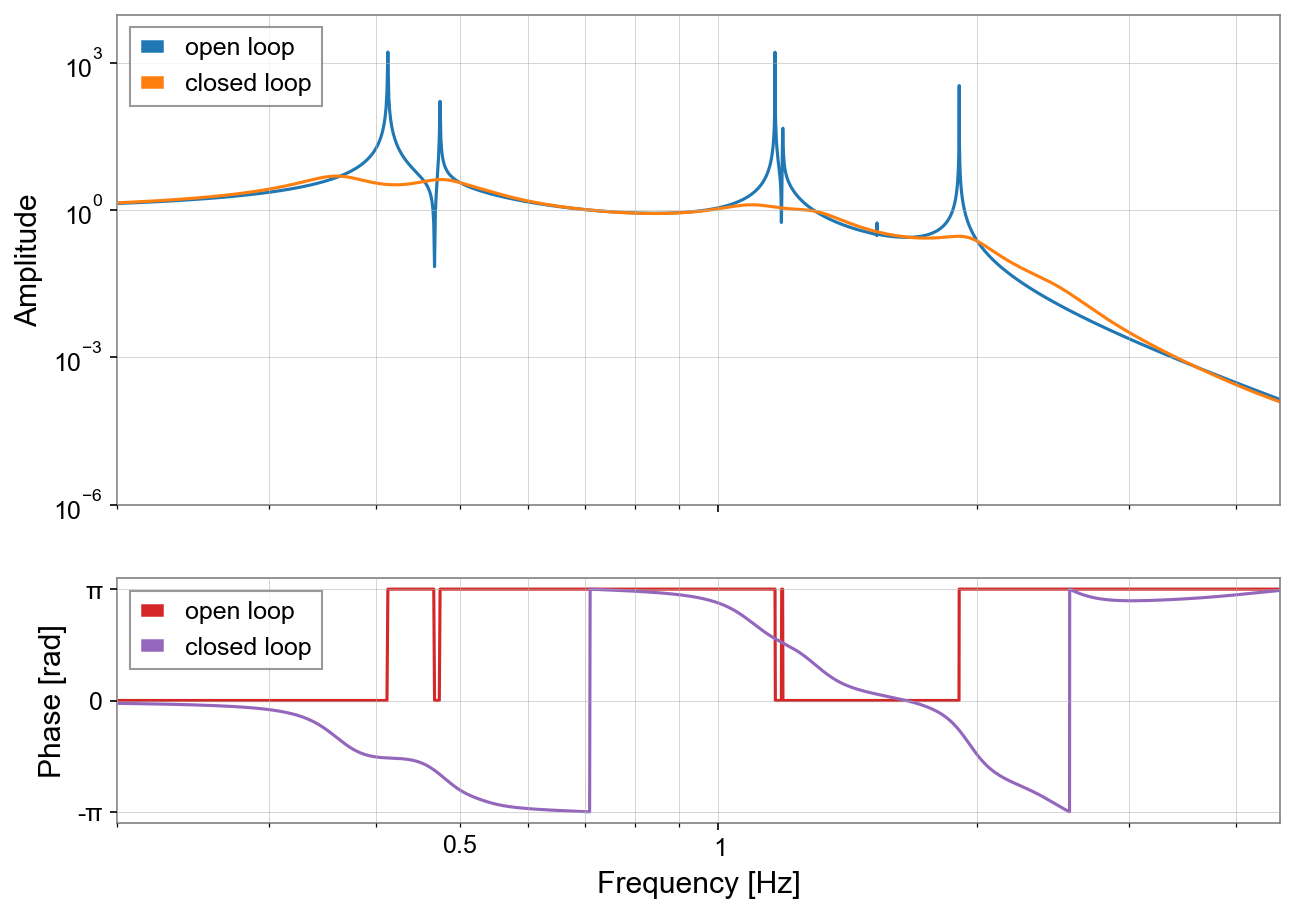

In [12]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, figsize=(10, 7), dpi = 150, sharex=True)
a0.loglog(Frequency_Array, mag_H, label = 'open loop')
a0.loglog(Frequency_Array, mag_controlled_sys, label = 'closed loop')
a0.set_ylabel('Amplitude')
a0.legend(loc = 'upper left')
a0.grid(True, which = 'both', linewidth = .25)
a0.set_yticks([1e-6, 1e-3, 1, 1e3])
a0.set_xlim(2e-1, 4.5)
a0.set_ylim(1e-6, )

a1.semilogx(Frequency_Array, phase_H, label = 'open loop', color = 'C3')
a1.semilogx(Frequency_Array, phase_controlled_sys, label = 'closed loop', color = 'C4')
a1.legend(loc = 'upper left')
a1.grid(True, which = 'both', linewidth = .25)
a1.set_xlabel('Frequency [Hz]')
a1.set_ylabel('Phase [rad]')
a1.set_yticks([-np.pi, 0, np.pi], labels = ["-π", 0, "π"])
a1.set_xlim(2e-1, 4.5)

plt.show()

#### Add seismic motion to system and plot freqeuncy response
The following code was written on the basis of another spicypy example: https://gitlab.com/pyda-group/spicypy/-/blob/main/examples/model_active_seismic_isolation_VATIGrav.ipynb

In [13]:
df_seismic = pd.read_csv('vatigrav_model/2022-05-20-13-44-59-1540000_5kHz_quiet_seis.csv')
s1x = df_seismic['S1X'] # seismometer 1, along X axis

# convert to time series with appropriate sample rate
from spicypy.signal.time_series import TimeSeries
input_seismic = TimeSeries(s1x[1500:], sample_rate=100) #removing first 1500 elements because we did "calibration jumps" in first few seconds
input_seismic = input_seismic[0:2000] # shortening input data, othervise response takes too long to run (but still possible if needed)

In [14]:
# Create correctly sized inputs list seeded with None values
U = [None for i in range(plant_sys.ninputs)]

# Assign seismic data to suspension input in x-direction
U[inSL] = input_seismic

### calculate time response ###
resp_open_loop = plant_sys.response(U)
resp_closed_loop = controlled_sys.response(U)

#### Plot time series of response to check if everything worked

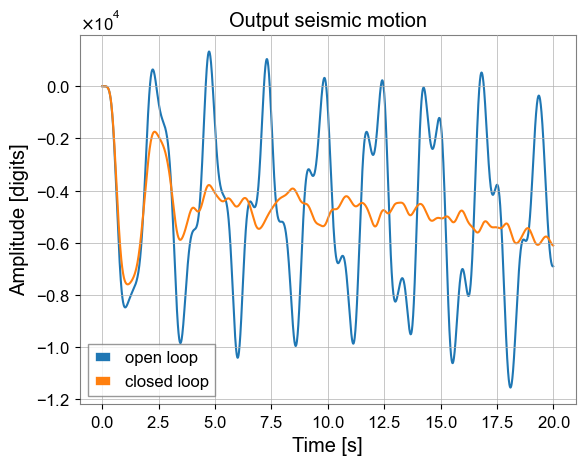

In [20]:
plt.plot(resp_open_loop[outM3L], color = 'C0', label="open loop")
plt.plot(resp_closed_loop[outM3L], color = 'C1', label="closed loop")
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [digits]') # we have time series in digits, conversion to meters is done on the final spectrum with the instrument transfer function
plt.title('Output seismic motion')
plt.legend()
plt.show()

#### Compute spectra of response and seismic input with lpsd algorithm and plot them

In [16]:
input_seismic_spectrum = input_seismic.asd(method = 'lpsd')
resp_open_loop_spectrum = resp_open_loop[outM3L].asd(method = 'lpsd')
resp_closed_loop_spectrum = resp_closed_loop[outM3L].asd(method = 'lpsd')

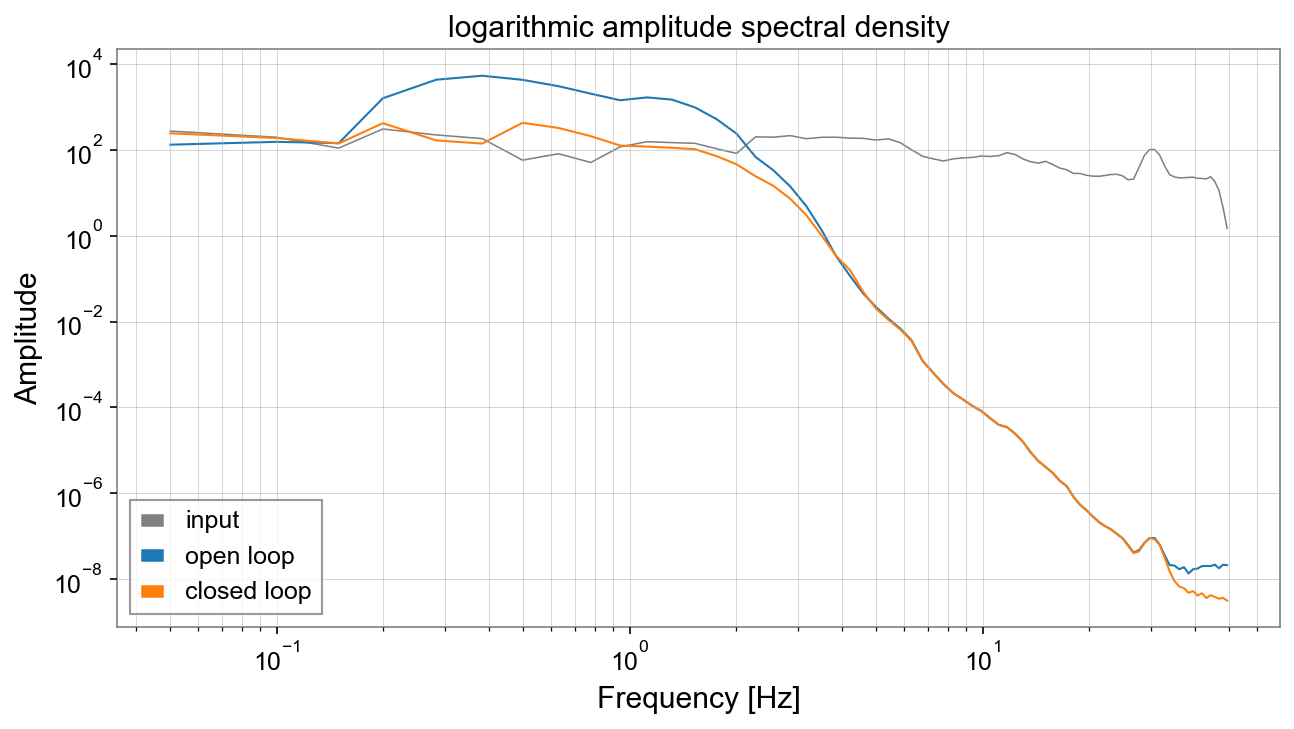

In [17]:
plt.figure(dpi = 150, figsize = (10, 5))
plt.loglog(input_seismic_spectrum, label='input', color='grey', lw=0.75)
plt.loglog(resp_open_loop_spectrum, label='open loop', color='C0', lw=1)
plt.loglog(resp_closed_loop_spectrum, label='closed loop', color='C1', lw=1)
plt.legend()
plt.grid(True, which = 'both', linewidth = .25)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.title('logarithmic amplitude spectral density')
plt.show()

#### Convert to proper units by multiplying with TF of trillium seismometers

In [18]:
### Define function to remove instrument response and get data in physical units###
from astropy.units import Unit
def instrument_response(asd):
    ''' Conversion from velocity to displacement using TF from Trillium Horizon 120

        Args:
            asd (FrequencySeries): input ASD in digits
        
        Returns:
            asd (FrequencySeries): output ASD in m/s
    '''
    ### Pole-Zero representation of Trillium Horizon tranfer function ###
    poles =  [-0.036614 +0.037059j, -0.036614 -0.037059j, -32.55, -142, -364 +404j, -364 -404j, -1260, -4900 +5200j, -4900 -5200j, -7100 +1700j, -7100 -1700j]
    zeros =  [0, 0, -31.63, -160, -350, -3177]
    scale_factor = 1202.5 * 8.31871e17 * 400000         #V/(m/s) times gain times counts/V

    num_poly_coef, denom_poly_coef = zpk2tf(
        zeros, poles, scale_factor)

    omega = 2 * np.pi * asd.frequencies.value
    _, resp = freqs(num_poly_coef, denom_poly_coef, omega)
    respamp = np.sqrt(np.absolute(resp*np.conjugate(resp)))
    asd = asd/respamp
    asd.override_unit(Unit("m*s(-1)/Hz(1/2)"))
    return asd

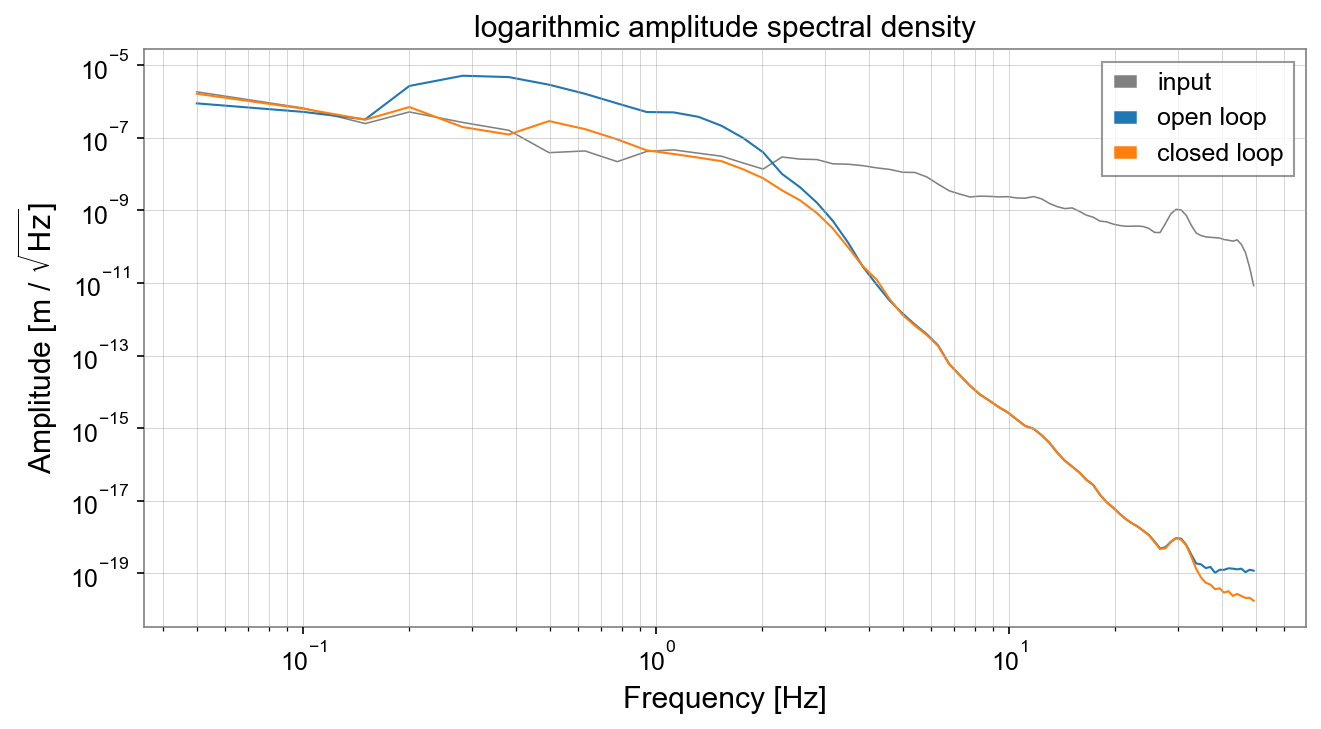

In [19]:
plt.figure(dpi = 150, figsize = (10, 5))
plt.loglog(instrument_response(input_seismic_spectrum).to_displacement(), label='input', color='grey', lw=0.75)
plt.loglog(instrument_response(resp_open_loop_spectrum).to_displacement(), label='open loop', color='C0', lw=1)
plt.loglog(instrument_response(resp_closed_loop_spectrum).to_displacement(), label='closed loop', color='C1', lw=1)
plt.legend()
plt.grid(True, which = 'both', linewidth = .25)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [m / $\\sqrt{\\mathrm{Hz}}$]')
plt.title('logarithmic amplitude spectral density')
plt.show()